In [385]:
import json

scientific_articles = []
with open('json/science.json', 'r') as storage:
    info = json.loads(storage.read())
    for article in info:
        scientific_articles.append(article[1])

conspiracy_articles = [] 
with open('json/conspiracy.json', 'r') as storage:
    info = json.loads(storage.read())
    for article in info:
        conspiracy_articles.append(article[1])

print(len(scientific_articles), len(conspiracy_articles))

min_len = min(len(scientific_articles), len(conspiracy_articles))
scientific_articles = scientific_articles[:min_len]
conspiracy_articles = conspiracy_articles[:min_len]

257 454


In [386]:
from sklearn.model_selection import train_test_split

training_science_set, test_science_set = train_test_split(scientific_articles, test_size = 0.2, random_state = 1)
training_conspiracy_set, test_conspiracy_set = train_test_split(conspiracy_articles, test_size = 0.2, random_state = 1)

In [387]:
training_set = training_science_set + training_conspiracy_set
test_set = test_science_set + test_conspiracy_set

In [388]:
len(training_set)

308

In [389]:
len(test_set)

206

In [390]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from dateutil.parser import parse
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

import string
import nltk

class BagOfWords:
    def __init__(self, tokenized_paragraph: list, is_positive: bool):
        self.sentences = tokenized_paragraph
        self.is_positive = is_positive

    def tokenize(self):
        self.words = []
        for sentence in self.sentences:
            for word in word_tokenize(sentence):
                self.words.append(word)

    def to_lower_case(self):
        for i in range(len(self.words)):
            self.words[i] = self.words[i].lower()

    def clean_data(self):
        noise = ['...', "n't"]
        def is_time_or_date(word):  
            try:
                parsed = parse(word)
                return True
            except:
                return False

        def is_link(word):
            suffixes = ['.com', '.org', '.edu', '.gov', '.int', '.co', '.net', '.au', '.us', '.uk', '.ne', 'news']
            for suffix in suffixes:
                if suffix in word:
                    return True
            return False

        for i in range(len(self.words)-1, -1, -1):
            if len(self.words[i]) <= 2 or self.words[i].isnumeric() or is_time_or_date(self.words[i]) or self.words[i] in noise or is_link(self.words[i]) or self.words[i] in [letter for letter in string.ascii_lowercase]:
                self.words.pop(i)
                continue
        
            # shave punctation off of beginnings and from the end
            start_ind, end_ind = -1, -1
            for j in range(len(self.words[i])):
                if self.words[i][j] in string.ascii_lowercase or self.words[i][j].isnumeric():
                    start_ind = j
                    break
            for j in range(len(self.words[i])-1, -1, -1):
                if self.words[i][j] in string.ascii_lowercase or self.words[i][j].isnumeric():
                    end_ind = j
                    break

            if (start_ind == 0 and end_ind == len(self.words[i])-1) or start_ind >= end_ind:
                continue

            self.words[i] = self.words[i][start_ind:end_ind+1]

    def remove_stop_words(self):
        for i in range(len(self.words)-1, -1, -1):
            if self.words[i] in stopwords.words('english'):
                self.words.pop(i)  

    def normalize_words(self):
        def get_part_of_speech(provided_word):
            _, part_of_speech = nltk.pos_tag([provided_word])[0]
            if 'NN' in part_of_speech:
                return 'n'
            if 'VB' in part_of_speech:
                return 'v'
            if 'JJ' in part_of_speech:
                return 'a'
            if 'RB' in part_of_speech:
                return 'r'
            return 'n'

        lemmatizer = WordNetLemmatizer()
        for i in range(len(self.words)):
            # if lemmatizer.lemmatize(self.words[i], get_part_of_speech(self.words[i])) == 'm':
            #     print(self.words[i])
            self.words[i] = lemmatizer.lemmatize(self.words[i], get_part_of_speech(self.words[i]))

        # perform some data cleaning on lemmatized words
        for i in range(len(self.words)-1, -1, -1):
            if self.words[i] in [letter for letter in string.ascii_lowercase]:
                self.words.pop(i)  

    def create_frequency_chart(self):
        self.freqChart = dict()

        for word in self.words:
            if word not in self.freqChart:
                self.freqChart[word] = 1
            else:
                self.freqChart[word] += 1

        # sorting in ascending order by value
        self.freqChart = {word: self.freqChart[word] for word in sorted(self.freqChart, key=self.freqChart.get, reverse=True)}

    def plot_frequency_chart(self):
        words = list(self.freqChart.keys())[:100]
        frequencies = list(self.freqChart.values())[:100]

        plt.figure(figsize=(20, 5))
        plt.margins(x=0, tight=True)
        plt.bar(words, frequencies, color ='green')

        # setting title and labels
        plt.xlabel("Distinct Words")
        plt.tick_params(axis='x', which='major', labelsize=9)
        plt.xticks(rotation = 90)

        plt.ylabel(f"Frequency of Words in {self.is_positive}")
        plt.title("Frequency Chart")

        # loading the plot
        plt.show()

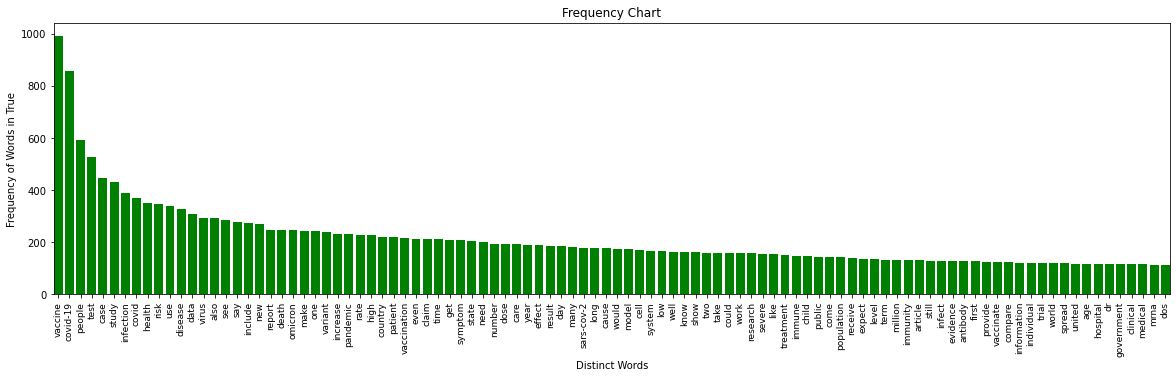

In [391]:
science_train = BagOfWords(training_science_set, True)

science_train.tokenize()
science_train.to_lower_case()
science_train.clean_data()
science_train.remove_stop_words()
science_train.normalize_words() # todo: improve part of speech performance
science_train.create_frequency_chart()
science_train.plot_frequency_chart()

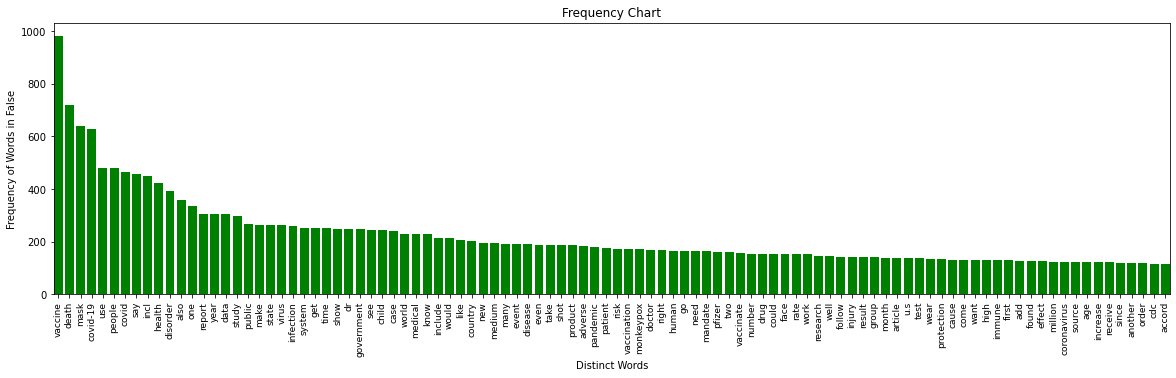

In [392]:
conspiracy_train = BagOfWords(training_conspiracy_set, False)

# assuming rn that everything is clean because of testing on 'a', will test later
conspiracy_train.tokenize()
conspiracy_train.to_lower_case()
conspiracy_train.clean_data()
conspiracy_train.remove_stop_words()
conspiracy_train.normalize_words() # todo: improve part of speech performance
conspiracy_train.create_frequency_chart()
conspiracy_train.plot_frequency_chart()

In [393]:
science_test = BagOfWords(test_science_set, True)

science_test.tokenize()
science_test.to_lower_case()
science_test.clean_data()
science_test.remove_stop_words()
science_test.normalize_words() # todo: improve part of speech performance
science_test.create_frequency_chart()
# plotting frequency is not relevant for test set

In [394]:
conspiracy_test = BagOfWords(test_conspiracy_set, False)

conspiracy_test.tokenize()
conspiracy_test.to_lower_case()
conspiracy_test.clean_data()
conspiracy_test.remove_stop_words()
conspiracy_test.normalize_words() # todo: improve part of speech performance
conspiracy_test.create_frequency_chart()
# plotting frequency is not relevant for test set

In [395]:
def get_common_words(a: BagOfWords, b: BagOfWords):
    # determine common words between the two sets of words
    common_words = dict()
    for word, count in a.freqChart.items():
        if word in b.freqChart:
            diff_count = count - b.freqChart[word]
            common_words[word] = diff_count/(count + b.freqChart[word])

    # remove all with count 0 
    common_words = dict(filter(lambda elem: elem[1] != 0, common_words.items()))

    # sorting the dictionary in descending order
    common_words = {word: common_words[word] for word in sorted(common_words, key=common_words.get, reverse=True)}

    return common_words

In [396]:
train_common_words = get_common_words(science_train, conspiracy_train)

In [397]:
train_common_words

{'jackson': 0.9797979797979798,
 'ba.5': 0.9661016949152542,
 'ba.2': 0.9591836734693877,
 'pot': 0.9545454545454546,
 'adhd': 0.9534883720930233,
 'screen': 0.944954128440367,
 'ba.4': 0.9444444444444444,
 'paris': 0.9166666666666666,
 'pericarditis': 0.9130434782608695,
 'preprint': 0.9130434782608695,
 'edit': 0.9130434782608695,
 'creative': 0.9130434782608695,
 'antibiotic': 0.9047619047619048,
 'interval': 0.8947368421052632,
 'seal': 0.8888888888888888,
 'diphtheria': 0.8823529411764706,
 'rick': 0.8823529411764706,
 'scammer': 0.8787878787878788,
 'surge': 0.8762886597938144,
 'cervical': 0.875,
 'text': 0.875,
 'swab': 0.875,
 'outweigh': 0.875,
 'hypothetical': 0.875,
 'bhattacharya': 0.875,
 'cardiovascular': 0.875,
 'variation': 0.8709677419354839,
 'placebo': 0.8666666666666667,
 'validate': 0.8666666666666667,
 'adjust': 0.8666666666666667,
 'pediatrics': 0.8666666666666667,
 'diet': 0.8620689655172413,
 'limitation': 0.8571428571428571,
 'renewable': 0.8571428571428571,


In [398]:
def get_stats_common_words(common_words):
    print(len(common_words), sep = ', ')
    print(sum(y > 0 for _, y in common_words.items()))
    print(sum(y < 0 for _, y in common_words.items()))

In [399]:
get_stats_common_words(train_common_words)

3735
1658
2077


In [400]:
def get_relevant_words(common_words, num_words = 500):
    # extract 20 most common words
    sorted_words = []
    for key, value in common_words.items():
        sorted_words.append([abs(value), key])
    sorted_words.sort(reverse=True)

    # take 20 with highest magnitudes  
    relevant_words = sorted_words[:num_words]

    # give the sign back
    for word in relevant_words:
        word[0] = common_words[word[1]]

    relevant_words.sort()
    return relevant_words

In [401]:
train_relevant_words = get_relevant_words(train_common_words, 200)

In [402]:
train_relevant_words

[[-0.9615384615384616, 'inject'],
 [-0.9534883720930233, 'surgical'],
 [-0.9473684210526315, 'intelligence'],
 [-0.9344262295081968, 'military'],
 [-0.9310344827586207, 'pharma'],
 [-0.9298245614035088, 'mainstream'],
 [-0.92, 'okay'],
 [-0.92, 'suspend'],
 [-0.9166666666666666, 'nutrition'],
 [-0.9154929577464789, 'wuhan'],
 [-0.9130434782608695, 'arrest'],
 [-0.9130434782608695, 'outlet'],
 [-0.9130434782608695, 'strike'],
 [-0.9090909090909091, 'relate'],
 [-0.9090909090909091, 'sudden'],
 [-0.9047619047619048, 'crime'],
 [-0.9047619047619048, 'gold'],
 [-0.9047619047619048, 'guard'],
 [-0.9047619047619048, 'guy'],
 [-0.9047619047619048, 'hidden'],
 [-0.9047619047619048, 'infestation'],
 [-0.9047619047619048, 'musculoskeletal'],
 [-0.9047619047619048, 'neoplasm'],
 [-0.9047619047619048, 'subcutaneous'],
 [-0.9047619047619048, 'thoracic'],
 [-0.9024390243902439, 'reproductive'],
 [-0.9, 'blame'],
 [-0.9, 'description'],
 [-0.8947368421052632, 'airway'],
 [-0.8947368421052632, 'dioxid

- split up data into testing, training set
    - in an 80-20 split
    - do this individually for scientific articles and conspiracy articles, then merge the two sets together
- after this, evaluation of well the system works with a ML model will be good
    - train model and redo-word frequency part once for the testing set and once for the training set (to prevent data leakage)
    - generate table for training and testing data (2 tables)
        - columns: for each of the 20 keywords
        - rows: count for each keyword in an article  
        - add a final column to the right displaying whether the article was a conspiracy or scientific (0 = conspiracy, 1 = scientific) 
    - train model with various different methods and evaluate test set  

In [403]:
import pandas as pd
import numpy as np

# build the dataframe
def build_training_dataframe(relevant_words):
    cols = {}
    for word in relevant_words:
        cols[word[1]] = []

    # adding scientific rows
    for article in training_science_set:
        for word in cols:
            cols[word].append(article.lower().count(word))

    # adding conspiracy row
    for article in training_conspiracy_set:
        for word in cols:
            cols[word].append(article.lower().count(word))

    data_set = pd.DataFrame(data = cols)

    row_count = data_set.shape[0]/2

    # setting scientific articles to 1
    data_set.loc[:row_count,'article_type'] = 1

    # setting conspiracy articles to 0
    data_set.loc[row_count:, 'article_type'] = 0

    return data_set

In [404]:
train_data = build_training_dataframe(train_relevant_words)

In [405]:
def build_test_dataframe(train_relevant_words):
    cols = {}
    for word in train_relevant_words:
        cols[word[1]] = []

    # adding scientific rows
    for article in test_science_set:
        for word in cols:
            cols[word].append(article.lower().count(word))

    # adding conspiracy row
    for article in test_conspiracy_set:
        for word in cols:
            cols[word].append(article.lower().count(word))

    data_set = pd.DataFrame(data = cols)

    row_count = data_set.shape[0]/2

    # setting scientific articles to 1
    data_set.loc[:row_count,'article_type'] = 1

    # setting conspiracy articles to 0
    data_set.loc[row_count:, 'article_type'] = 0

    return data_set

In [406]:
test_data = build_test_dataframe(train_relevant_words)

In [407]:
def no_elem_check(data_set):
    # make sure no columns have 0s for all the rows, should be true
    for col in data_set:
        unique_elem = data_set[col].unique()
        if len(unique_elem) == 0 and unique_elem[0] == 0:
            print(col)

In [408]:
train_data.columns

Index(['inject', 'surgical', 'intelligence', 'military', 'pharma',
       'mainstream', 'okay', 'suspend', 'nutrition', 'wuhan',
       ...
       'preprint', 'paris', 'ba.4', 'screen', 'adhd', 'pot', 'ba.2', 'ba.5',
       'jackson', 'article_type'],
      dtype='object', length=201)

In [409]:
train_data

,inject,surgical,intelligence,military,pharma,mainstream,okay,suspend,nutrition,wuhan,...,preprint,paris,ba.4,screen,adhd,pot,ba.2,ba.5,jackson,article_type
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,25,0,0,0,1,0,0,0,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,1,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0.0
304,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0.0
305,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
306,0,65,0,1,5,0,0,0,0,0,...,0,1,0,0,1,27,0,0,0,0.0


In [410]:
test_data

,inject,surgical,intelligence,military,pharma,mainstream,okay,suspend,nutrition,wuhan,...,preprint,paris,ba.4,screen,adhd,pot,ba.2,ba.5,jackson,article_type
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,49,1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,0,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0.0
202,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
203,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0
204,1,0,0,0,0,2,0,5,0,1,...,0,0,0,0,0,1,0,0,0,0.0


In [411]:
# get unique elements in column
def get_unique_col(data_set, col_name):
    return data_set[col_name].unique()

# get unique elements in column but for only those with a certain feature 
def get_unique_col(data_set, col_name, article_type):
    return data_set[data_set['article_type'] == article_type][col_name].unique()

In [412]:
get_unique_col(train_data, 'mainstream', 0)

array([ 0,  1, 11,  3,  2,  5])

In [413]:
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]

In [414]:
X_train

,inject,surgical,intelligence,military,pharma,mainstream,okay,suspend,nutrition,wuhan,...,pericarditis,preprint,paris,ba.4,screen,adhd,pot,ba.2,ba.5,jackson
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,25,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,1,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
304,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
305,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
306,0,65,0,1,5,0,0,0,0,0,...,0,0,1,0,0,1,27,0,0,0


In [415]:
y_train

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
303    0.0
304    0.0
305    0.0
306    0.0
307    0.0
Name: article_type, Length: 308, dtype: float64

In [416]:
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

In [417]:
def get_frequency(data_set):
    return (data_set != 1).values.sum()/len(data_set) * 100

print(get_frequency(y_train))
print(get_frequency(y_test))

50.0
50.0


In [418]:
# logistic regression
from sklearn.linear_model import LogisticRegression
lg_model = LogisticRegression(random_state = 1, max_iter = 10000)

lg_model.fit(X_train, y_train)
lg_pred = lg_model.predict(X_test)

In [419]:
# linear discriminant analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_model = LinearDiscriminantAnalysis()

lda_model.fit(X_train, y_train)
lda_pred = lda_model.predict(X_test)

In [420]:
# k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=15)

knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

In [421]:
# naive-bayes
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()

nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)

In [422]:
# decision tree
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state = 1)

dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

In [423]:
# support-vector machine
from sklearn.svm import SVC
svc_model = SVC(kernel = 'linear',gamma = 'scale', shrinking = False)

svc_model.fit(X_train, y_train)
svc_pred = svc_model.predict(X_test)

In [424]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [425]:
print(classification_report(y_test, lg_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.74      0.77       103
         1.0       0.76      0.83      0.79       103

    accuracy                           0.78       206
   macro avg       0.78      0.78      0.78       206
weighted avg       0.78      0.78      0.78       206



In [426]:
print(classification_report(y_test, lda_pred))

              precision    recall  f1-score   support

         0.0       0.68      0.51      0.59       103
         1.0       0.61      0.76      0.68       103

    accuracy                           0.64       206
   macro avg       0.64      0.64      0.63       206
weighted avg       0.64      0.64      0.63       206



In [427]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.34      0.48       103
         1.0       0.58      0.92      0.71       103

    accuracy                           0.63       206
   macro avg       0.70      0.63      0.60       206
weighted avg       0.70      0.63      0.60       206



In [428]:
print(classification_report(y_test, nb_pred))

              precision    recall  f1-score   support

         0.0       0.74      0.62      0.68       103
         1.0       0.68      0.79      0.73       103

    accuracy                           0.70       206
   macro avg       0.71      0.70      0.70       206
weighted avg       0.71      0.70      0.70       206



In [429]:
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.63      0.71       103
         1.0       0.70      0.84      0.76       103

    accuracy                           0.74       206
   macro avg       0.75      0.74      0.73       206
weighted avg       0.75      0.74      0.73       206



In [430]:
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.61      0.68       103
         1.0       0.68      0.83      0.75       103

    accuracy                           0.72       206
   macro avg       0.73      0.72      0.72       206
weighted avg       0.73      0.72      0.72       206

